In [1]:
# default_exp train

In [2]:
# export
from fastai2.basics import *
from fastai2.vision.all import *
from physionet2020.preprocess import *

## Load data

In [3]:
df = pd.read_csv(meta_trn_pth).set_index('PID')
df.head()

,Age,Sex,Dx,Rx,Hx,Sx,Normal,AF,I-AVB,LBBB,RBBB,PAC,PVC,STD,STE
PID,,,,,,,,,,,,,,,
A1516,82.0,Male,PAC,Unknown,Unknown,Unknows,0,0,0,0,0,1,0,0,0
A2989,87.0,Female,RBBB,Unknown,Unknown,Unknows,0,0,0,0,1,0,0,0,0
A0109,75.0,Female,"AF,RBBB",Unknown,Unknown,Unknows,0,1,0,0,1,0,0,0,0
A3465,24.0,Female,Normal,Unknown,Unknown,Unknows,1,0,0,0,0,0,0,0,0
A5081,65.0,Male,PVC,Unknown,Unknown,Unknows,0,0,0,0,0,0,1,0,0


In [4]:
df[cols].mean()

Normal    0.133488
AF        0.177548
I-AVB     0.104988
LBBB      0.034317
RBBB      0.270031
PAC       0.089574
PVC       0.101789
STD       0.126363
STE       0.031991
dtype: float64

In [5]:
#export
def pad_batch(x, pad_to=3000, value=-1):
    bs_pad = pad_to-x.shape[-1]
    pad = [0]*len(x.shape)
    pad[-1] = bs_pad
    return F.pad(x, pad=pad, value=value)[:,:pad_to]

class OpenEEG():
    def __init__(self, df, path, max_ts=4000):
        self.df = df
        self.path = path
        self.max_ts = max_ts
    def x(self, pid): 
        p = self.path/f'{pid}.npy'
        val = np.load(str(p)).astype(np.float32)
        return pad_batch(torch.from_numpy(val), pad_to=self.max_ts)
    def y(self, pid): 
        vals = self.df.loc[pid,cols].values.astype(np.float32)
        return vals

In [6]:
ids = df.index.values
splits = RandomSplitter()(ids)
tfm = OpenEEG(df, trn_path)
dsets = Datasets(ids, [[tfm.x], [tfm.y]], splits=splits)

In [7]:
x,y = dsets[0]
x.shape, y

(torch.Size([12, 4000]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32))

In [8]:
bs = 32
dls = dsets.dataloaders(bs=bs, num_workers=2)

In [9]:
szs = [12, 32, 64, 128, 256]
m = nn.Sequential(
    *[ResBlock(1, szs[i], szs[i+1], ndim=1, stride=2) for i in range(len(szs)-1)],
    AdaptiveAvgPool(1, ndim=1),
    Flatten(),
    nn.Linear(szs[-1], len(cols))
).cuda()

In [10]:
lf = BCEWithLogitsLossFlat

In [11]:
xb,yb = dls.one_batch()
l = lf()
out = m(xb)
loss = l(out, yb)
loss, xb.shape, out.shape

(tensor(0.6832, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 torch.Size([32, 12, 4000]),
 torch.Size([32, 9]))

In [12]:
fscore = FBetaMulti(2)
learn = Learner(dls, m, loss_func=lf(), lr=3e-3, metrics=[accuracy_multi, fscore])

In [13]:
learn.summary()

Sequential (Input shape: ['32 x 12 x 4000'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               32 x 32 x 2000       1,152      True      
________________________________________________________________
BatchNorm1d          32 x 32 x 2000       64         True      
________________________________________________________________
ReLU                 32 x 32 x 2000       0          False     
________________________________________________________________
Conv1d               32 x 32 x 2000       3,072      True      
________________________________________________________________
BatchNorm1d          32 x 32 x 2000       64         True      
________________________________________________________________
AvgPool1d            32 x 12 x 2000       0          False     
________________________________________________________________
Conv1d               32 x 32 x 2000       384        True      
_____________________________________________________

(0.13182567358016967, 0.004365158267319202)

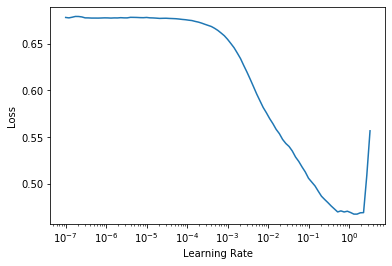

In [14]:
learn.lr_find()

In [15]:
# RANDOM ACCURACY BASELINE
1 - df[cols].values.mean()

0.8811012553923707

In [16]:
learn.fit_one_cycle(8, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.284160,0.265294,0.902950,0.219841,00:09
1,0.261938,0.226259,0.919434,0.332783,00:08
2,0.214791,0.216178,0.919515,0.383879,00:08
3,0.204566,0.189549,0.930344,0.456513,00:08
4,0.182721,0.176464,0.935515,0.487816,00:08
5,0.163457,0.154874,0.946101,0.570384,00:08
6,0.146864,0.146124,0.948606,0.595599,00:08
7,0.138962,0.145110,0.949253,0.605283,00:08
